In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm

https://climateknowledgeportal.worldbank.org/download-data

In [ ]:
df = pd.read_csv('tas_timeseries_monthly_cru_1901-2021_POL.csv', delimiter=',').set_index('Year')
df = df.T
df = pd.melt(df)

startdate = datetime(year=1900, month=1, day=1)
dates = [startdate + relativedelta(months=i) for i in range(len(df['Year']))]
dates_numbers = [1900 + 1/12 * i for i in range(len(df['Year']))]
temperatures = df['value']
df['Year'] = dates_numbers

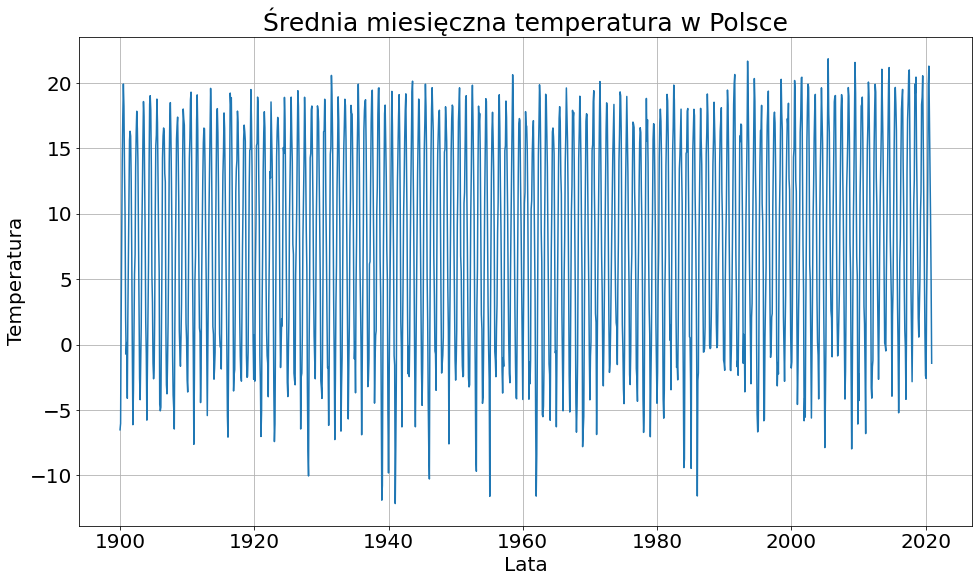

In [ ]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Średnia miesięczna temperatura w Polsce', fontsize=25)
plt.xlabel('Lata', fontsize=20)
plt.ylabel('Temperatura', fontsize=20)
plt.plot(dates, temperatures)
plt.grid()
plt.show()

In [ ]:
len(temperatures)

1452

In [ ]:
np.mean(temperatures), np.median(temperatures), np.var(temperatures), np.std(temperatures)

(7.9344559228650136, 8.684999999999999, 65.46145404282296, 8.090825300476025)

In [ ]:
np.percentile(temperatures, 75) - np.percentile(temperatures, 25)

14.79

In [ ]:
np.percentile(temperatures, 25), np.percentile(temperatures, 50), np.percentile(temperatures, 75)

(0.6475, 8.684999999999999, 15.4375)

In [ ]:
max(temperatures), min(temperatures)

(21.85, -12.16)

In [ ]:
max(temperatures) - min(temperatures)

34.010000000000005

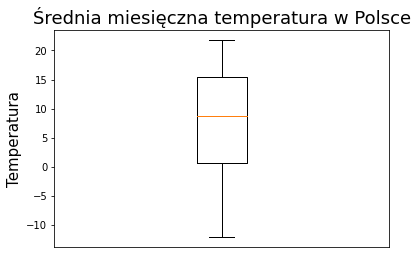

In [ ]:
plt.boxplot(temperatures)
plt.xticks(fontsize=20)
plt.title('Średnia miesięczna temperatura w Polsce', fontsize=18)
plt.ylabel('Temperatura', fontsize=15)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [ ]:
int(len(temperatures)*0.1), len(temperatures) - int(len(temperatures)*0.1)

(145, 1307)

In [ ]:
train_set = temperatures[:len(temperatures) - int(len(temperatures)*0.1)]
dates_numbers_train = dates_numbers[:len(temperatures) - int(len(temperatures)*0.1)]
test_set = temperatures[-int(len(temperatures)*0.1):]
dates_numbers_test = dates_numbers[-int(len(temperatures)*0.1):]

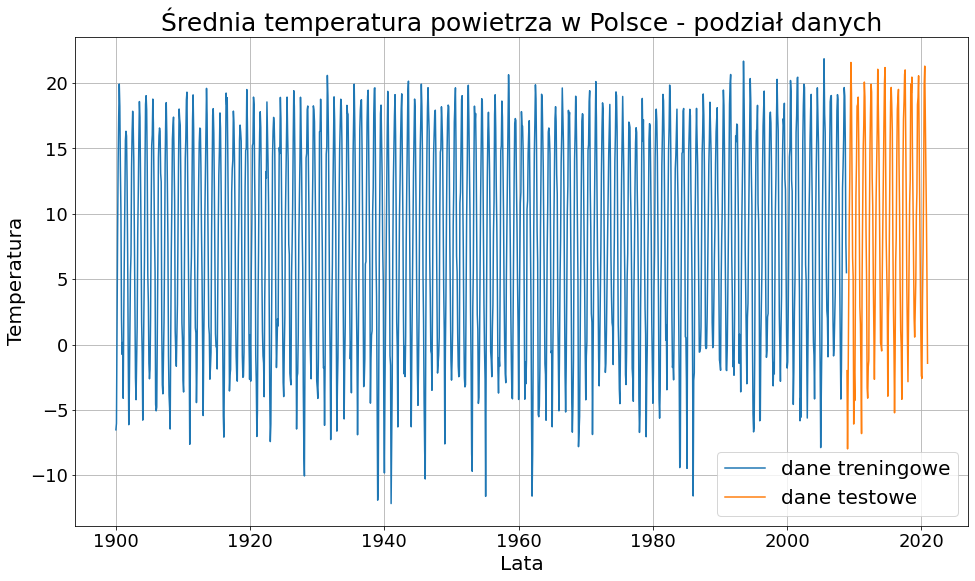

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(dates_numbers_train, train_set, label='dane treningowe')
plt.plot(dates_numbers_test, test_set, label='dane testowe')
plt.legend(prop={'size': 20})
plt.title("Średnia temperatura powietrza w Polsce - podział danych", fontsize=25)
plt.ylabel('Temperatura', fontsize=20)
plt.xlabel('Lata', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

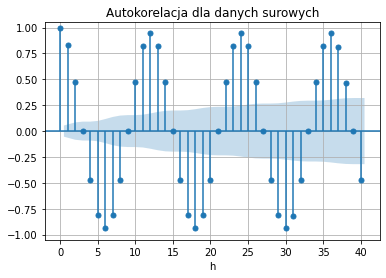

In [ ]:
h = 40
plot_acf(train_set, lags=h, adjusted=True)
plt.title("Autokorelacja dla danych surowych")
plt.xlabel('h')
plt.ylim(-1.05, 1.05)
plt.grid()
plt.savefig("wykres3.pdf")
plt.show()

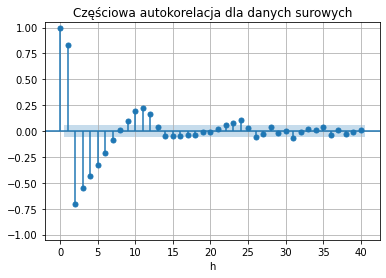

In [ ]:
plot_pacf(train_set, lags=h, method='ywm')
plt.title("Częściowa autokorelacja dla danych surowych")
plt.ylim(-1.05, 1.05)
plt.xlabel('h')
plt.grid()
plt.savefig("wykres4.pdf")
plt.show()

In [ ]:
result = STL(train_set, period=12, seasonal=71, trend=1311).fit()

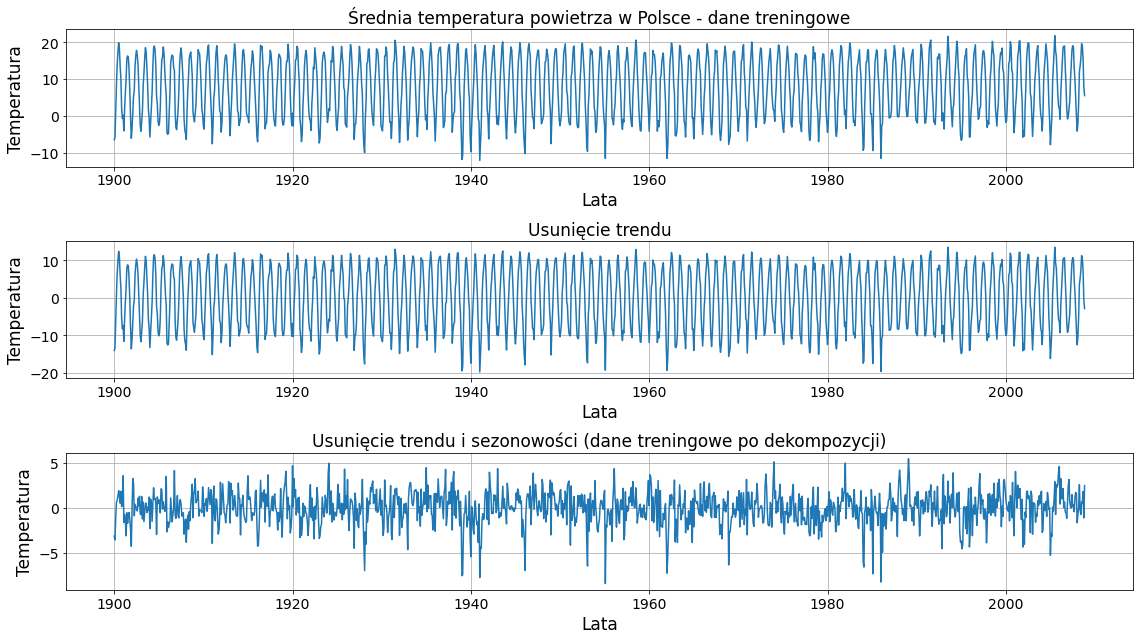

In [ ]:
plt.figure(figsize=(16, 9))
plt.subplot(3, 1, 1)
plt.plot(dates_numbers_train, train_set)
plt.title("Średnia temperatura powietrza w Polsce - dane treningowe", fontsize=17)
plt.ylabel('Temperatura', fontsize=17)
plt.xlabel('Lata',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.subplot(3, 1, 2)
plt.plot(dates_numbers_train, train_set - result.trend)
plt.title("Usunięcie trendu", fontsize=17)
plt.ylabel('Temperatura', fontsize=17)
plt.xlabel('Lata',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.subplot(3, 1, 3)
plt.plot(dates_numbers_train, train_set - result.trend - result.seasonal)
plt.title("Usunięcie trendu i sezonowości (dane treningowe po dekompozycji)", fontsize=17)
plt.ylabel('Temperatura', fontsize=17)
plt.xlabel('Lata',fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig("wykres5.pdf")

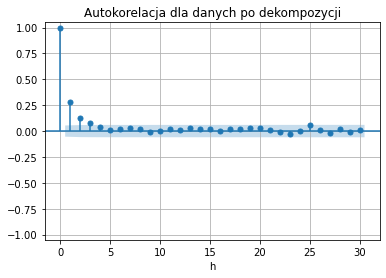

In [ ]:
h = 30
plot_acf(train_set - result.trend - result.seasonal, lags=h, adjusted=True)
plt.title("Autokorelacja dla danych po dekompozycji")
plt.ylim(-1.05, 1.05)
plt.xlabel('h')
plt.grid()
plt.savefig("wykres6.pdf")
plt.show()

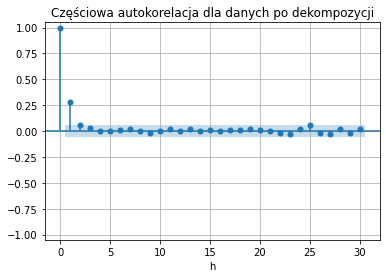

In [ ]:
plot_pacf(train_set - result.trend - result.seasonal, lags=h, method='ywm')
plt.title("Częściowa autokorelacja dla danych po dekompozycji")
plt.ylim(-1.05, 1.05)
plt.xlabel('h')
plt.grid()
plt.savefig("wykres7.pdf")
plt.show()

# Dopasowanie trendu

In [ ]:
p = np.polyfit(range(0, 1307), train_set, 1)

In [ ]:
p[0], p[1]

(0.0007774599737828294, 7.298187038037946)

# Dopasowanie sezonowości

In [ ]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0, guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [ ]:
fit_sin(range(0, 1307), train_set-result.trend)['rawres'][1] # A * numpy.sin(w*t + p) + c

array([11.09060292,  0.52360062, -1.60503844, -0.02266336])

# test ADF dla surowych danych (1) i obrobionych (2)

In [ ]:
# Testowanie stacjonarności
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag="t-stat", maxlag=60)
    p_value = round(res[1], 3)
    stats   = round(res[0], 3)

    print(res)

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [ ]:
adfuller_test(df['value'])

(-2.3025695951868514, 0.17114056522619198, 59, 1392, {'1%': -3.435056465447021, '5%': -2.8636185648927617, '10%': -2.567876622097536}, 4.046184309784791)
Statystyka testowa = -2.303, p-value = 0.171 => Non-stationary.


In [ ]:
adfuller_test(result.resid)

(-6.599334040086793, 6.798064831153985e-09, 47, 1259, {'1%': -3.435554672689999, '5%': -2.863838402102491, '10%': -2.5679936943096284}, 2.544172091151222)
Statystyka testowa = -6.599, p-Value = 0.0 => Stationary. 


# Modelowanie danych przy pomocy ARMA

In [ ]:
data = train_set - result.trend - result.seasonal

df = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 3
max_q = 3

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(data, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

In [ ]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
4,1,1,5217.497202,5238.199161,5225.262570
6,2,0,5218.394309,5239.096267,5226.159677
5,1,2,5219.241291,5245.118740,5228.948002
7,2,1,5219.268703,5245.146152,5228.975413
3,1,0,5220.978327,5236.504797,5226.802353


In [ ]:
df.sort_values(by='BIC').head()

,p,q,AIC,BIC,HQIC
3,1,0,5220.978327,5236.504797,5226.802353
4,1,1,5217.497202,5238.199161,5225.262570
6,2,0,5218.394309,5239.096267,5226.159677
2,0,2,5224.350257,5245.052215,5232.115625
5,1,2,5219.241291,5245.118740,5228.948002


In [ ]:
df.sort_values(by='HQIC').head()

,p,q,AIC,BIC,HQIC
4,1,1,5217.497202,5238.199161,5225.262570
6,2,0,5218.394309,5239.096267,5226.159677
3,1,0,5220.978327,5236.504797,5226.802353
5,1,2,5219.241291,5245.118740,5228.948002
7,2,1,5219.268703,5245.146152,5228.975413


In [ ]:
p = 1
q = 1

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p, q = 1, 1

model = ARIMA(data, order=(p, 0, q)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1307
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2604.749
Date:                Thu, 09 Feb 2023   AIC                           5217.497
Time:                        12:01:13   BIC                           5238.199
Sample:                             0   HQIC                          5225.263
                               - 1307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0237      0.078     -0.303      0.762      -0.177       0.129
ar.L1          0.4977      0.083      6.018      0.000       0.336       0.660
ma.L1         -0.2407      0.090     -2.672      0.0

# Ocena dopasowania modelu

In [ ]:
def autokowariancja(x,h):
    n = len(x)
    acrf=0
    for i in range(1, n-abs(h)):
        acrf=acrf+(x[i+abs(h)]-np.mean(x))*(x[i]-np.mean(x))
    acrf=acrf/n

    return acrf

def autokorelacja(x,h):
    acf = autokowariancja(x,h)/autokowariancja(x,0)

    return acf

In [ ]:
p1 = 0.4977
q1 = -0.2407

ar_coef = np.array([1, -p1])
ma_coef = np.array([1, q1])

arma_process = ArmaProcess(ar_coef, ma_coef).generate_sample(nsample=len(train_set), scale=2)

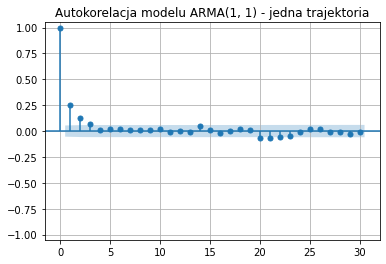

In [ ]:
h = 30
plot_acf(arma_process, lags=h, adjusted=True)
plt.title("Autokorelacja modelu ARMA(1, 1) - jedna trajektoria")
plt.ylim(-1.05, 1.05)
plt.grid()
plt.show()

In [ ]:
arma_process = ArmaProcess(ar_coef, ma_coef).generate_sample(nsample=len(train_set), scale=2)

In [ ]:
hs = [[] for _ in range(1, 21)]
hs2 = [[] for _ in range(1, 21)]
yyy = []
for i in range(100):
    arma_process = ArmaProcess(ar_coef, ma_coef).generate_sample(nsample=len(train_set), scale=2)
    yyy.append(arma_process)
    for h in range(1, 20):
        hs[h].append(autokorelacja(arma_process, h))
        hs2[h].append(pacf(arma_process)[h])

In [ ]:
q10 = []
q20 = []
q30 = []
q40 = []
q50 = []
q60 = []
q70 = []
q80 = []
q90 = []

for i in range(len(train_set)):
    listt = []
    for j in range(100):
        listt.append(yyy[j][i])
    q10.append(np.quantile(listt, 0.1))
    q20.append(np.quantile(listt, 0.2))
    q30.append(np.quantile(listt, 0.3))
    q40.append(np.quantile(listt, 0.4))
    q50.append(np.quantile(listt, 0.5))
    q60.append(np.quantile(listt, 0.6))
    q70.append(np.quantile(listt, 0.7))
    q80.append(np.quantile(listt, 0.8))
    q90.append(np.quantile(listt, 0.9))

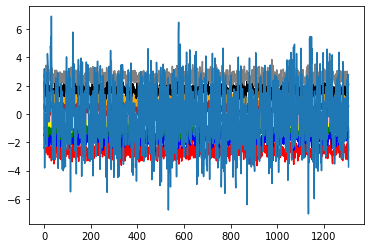

In [ ]:
plt.plot(q10, 'red')
plt.plot(q20, 'blue')
plt.plot(q30, 'green')
plt.plot(q40, 'yellow')
plt.plot(q50, 'pink')
plt.plot(q60, 'brown')
plt.plot(q70, 'orange')
plt.plot(q80, 'black')
plt.plot(q90, 'gray')
plt.plot(arma_process)

In [ ]:
q05, q95 = [1], [1]
pacf05, pacf95 = [1], [1]
for h in range(1, 20):
    q05.append(np.quantile(hs[h], 0.05))
    q95.append(np.quantile(hs[h], 0.95))
    pacf05.append(np.quantile(hs2[h], 0.05))
    pacf95.append(np.quantile(hs2[h], 0.95))

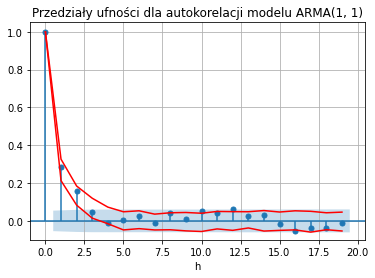

In [ ]:
plot_acf(arma_process, lags=h, adjusted=True)
plt.title("Przedziały ufności dla autokorelacji modelu ARMA(1, 1)")
plt.ylim(-0.1, 1.05)
plt.xlabel('h')
plt.grid()
plt.plot(q95, 'red')
plt.plot(q05, 'red')
plt.savefig("wykres9.pdf")

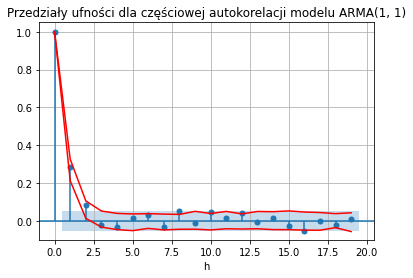

In [ ]:
plot_pacf(arma_process, lags=h, method='ywm')
plt.title("Przedziały ufności dla częściowej autokorelacji modelu ARMA(1, 1)")
plt.ylim(-0.1, 1.05)
plt.grid()
plt.xlabel('h')
plt.plot(pacf05, 'red')
plt.plot(pacf95, 'red')
plt.savefig("wykres10.pdf")

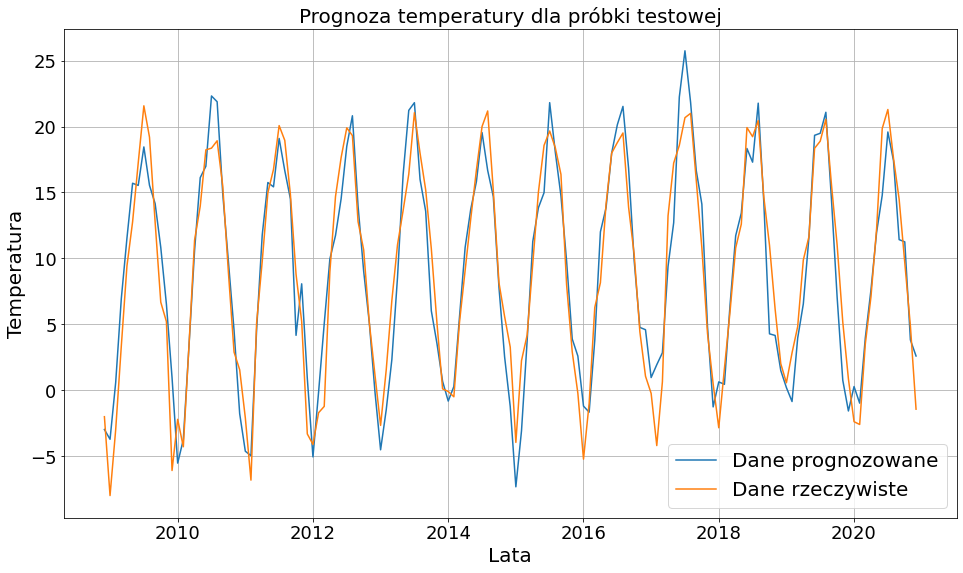

In [ ]:
plt.figure(figsize=(16, 9))
arma_process = ArmaProcess(ar_coef, ma_coef).generate_sample(nsample=1452, scale=2)
result = STL(test_set, period=12, seasonal=71, trend=1311).fit()
plt.plot(dates_numbers_test, arma_process[1307:]+result.seasonal+result.trend, label='Dane prognozowane')
plt.plot(dates_numbers_test, test_set, label='Dane rzeczywiste')
plt.legend(prop={'size': 20})
plt.title('Prognoza temperatury dla próbki testowej', fontsize=20)
plt.ylabel('Temperatura', fontsize=20)
plt.xlabel('Lata', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

# Weryfikacja założeń dotyczących szumu

In [ ]:
resid = model.resid
params = model.params

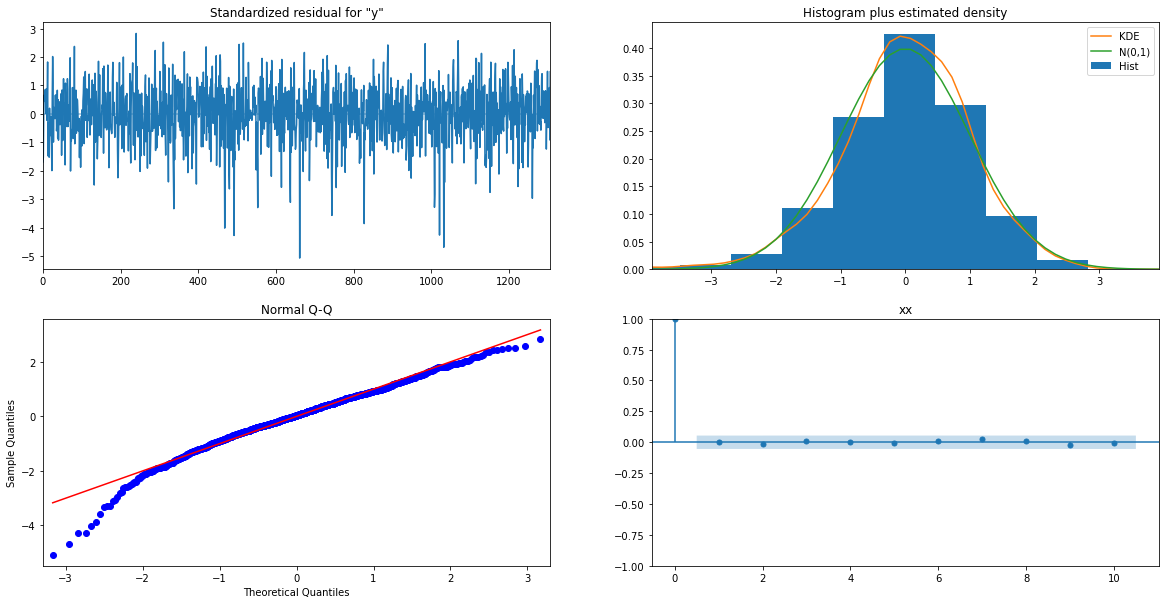

In [ ]:
model.plot_diagnostics(0,figsize=(20,10))
plt.title('xx')
plt.plot();

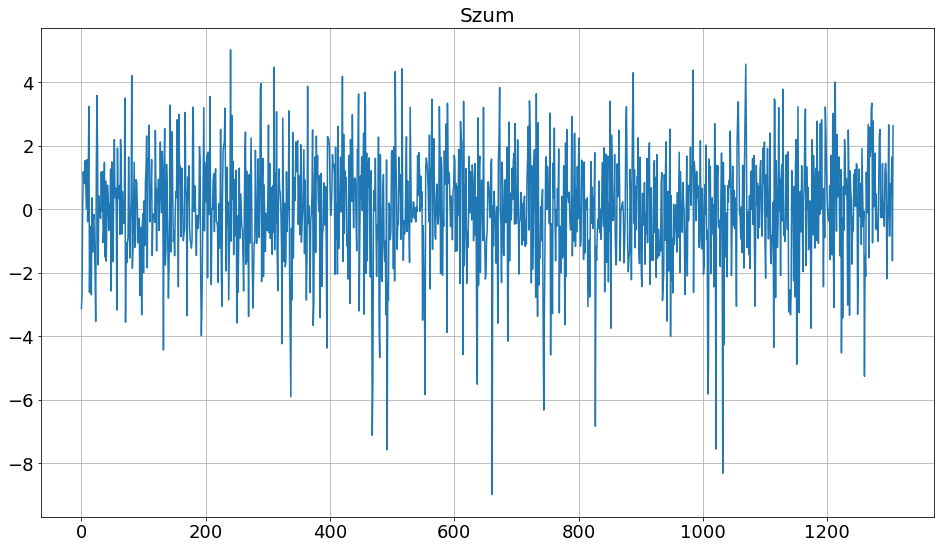

In [ ]:
resid = model.resid
plt.figure(figsize=(16, 9))
plt.plot(resid)
plt.title('Szum', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()

In [ ]:
np.mean(resid)

0.0012231001239969516

In [ ]:
np.var(resid)

3.1521923755190064

In [ ]:
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

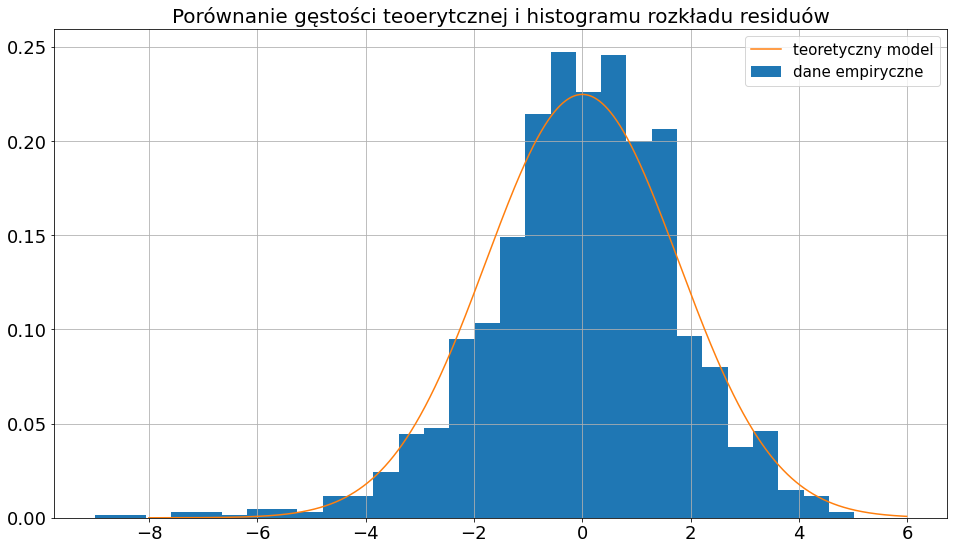

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Porównanie gęstości teoerytcznej i histogramu rozkładu residuów', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.hist(resid, bins=30, density=True, label='dane empiryczne')
plt.plot(np.arange(-8, 6, 0.01), norm.pdf(np.arange(-8, 6, 0.01), np.mean(resid), np.std(resid)), label='teoretyczny model')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

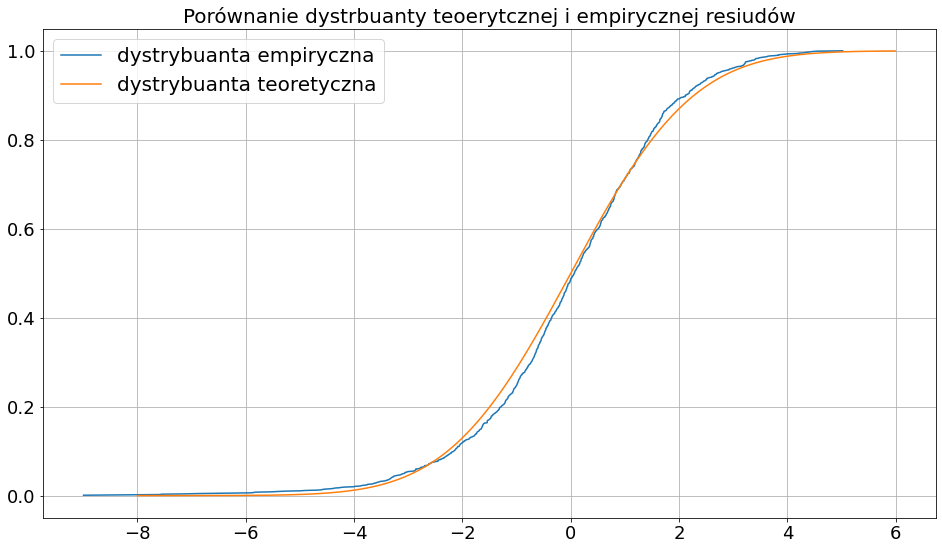

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Porównanie dystrbuanty teoerytcznej i empirycznej resiudów', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ecdf = ECDF(resid)
plt.plot(ecdf.x, ecdf.y, label='dystrybuanta empiryczna')
plt.plot(np.arange(-8, 6, 0.01), norm.cdf(np.arange(-8, 6, 0.01), np.mean(resid), np.std(resid)), label='dystrybuanta teoretyczna')
plt.legend(prop={'size': 20})
plt.grid()
plt.show()

In [ ]:
stats.kstest(resid, "norm", alternative='less')

KstestResult(statistic=0.13906961097613513, pvalue=8.163152845844457e-23)

In [ ]:
from scipy.stats import ttest_1samp

In [ ]:
ttest_1samp(resid, popmean=155)

Ttest_1sampResult(statistic=-3154.9574215894277, pvalue=0.0)

In [ ]:
from statsmodels.stats.diagnostic import het_arch

het_arch(resid)

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:657: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  warnings.warn("The default value of nlags is changing.  After 0.12, "


(116.00062651221468,
 2.168151321454478e-14,
 5.440770838509022,
 3.687465775368631e-15)

In [ ]:
from scipy.stats import levene

In [ ]:
levene(resid, norm.rvs(np.mean(resid), np.std(resid), 100))

LeveneResult(statistic=0.18772998287623105, pvalue=0.6648791953643298)

In [ ]:
import statsmodels.api as sm

In [ ]:
sm.stats.acorr_ljungbox(resid, return_df=True)

C:\Users\patry\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "


,lb_stat,lb_pvalue
1,0.002323,0.961559
2,0.162452,0.921985
3,0.404529,0.939305
4,0.404805,0.982082
5,0.522189,0.991288
6,0.570764,0.996868
7,1.423657,0.984836
8,1.589243,0.991125
9,2.099267,0.989799
10,2.200888,0.994556


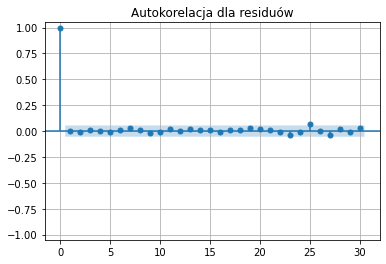

In [ ]:
h = 30
plot_acf(resid, lags=h, adjusted=True)
plt.title("Autokorelacja dla residuów")
plt.ylim(-1.05, 1.05)
plt.grid()
plt.show()

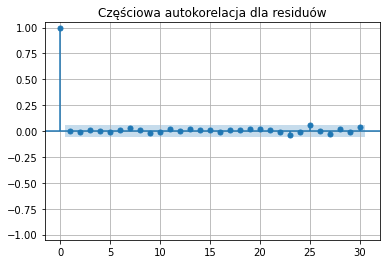

In [ ]:
plot_pacf(resid, lags=h, method='ywm')
plt.title("Częściowa autokorelacja dla residuów")
plt.ylim(-1.05, 1.05)
plt.grid()
plt.show()